# Libraries

In [12]:
import numpy as np
import pandas as pd
from darts.models import AutoARIMA
from darts.metrics import smape
from darts import TimeSeries
from darts.dataprocessing.transformers import Scaler
import matplotlib.pyplot as plt
from statsmodels.stats.outliers_influence import variance_inflation_factor
%matplotlib inline

# Functions

In [13]:
def predict_df_aarima(external_varaibles, forecast_len):
    """builds dataframe of predictions using AutoARIMA model"""

    #convert dataset into time series
    dataset_ts = external_varaibles

    #create empty dataframe to place results into
    predictions_df = pd.DataFrame()

    #loop through all external variables and generate predictions
    for name in list(external_varaibles.columns):
        
        #fitting AutoARIMA to predict
        model = AutoARIMA(information_criterion = 'hqic', seasonal=True, add_encoders = {'transformer':Scaler()})
        
        model.fit(dataset_ts[name])
        forecast = model.predict(forecast_len)
        predictions_df[name] = TimeSeries.pd_dataframe(forecast)

    return TimeSeries.from_dataframe(predictions_df)
        
def accuracy_score(a, f):
    return 100 - smape(a, f)


def high_cor_var(df, target, columns, threshold = 0.5):
    """Takes in dataframe and selects columns based on pearson correlation"""
    df_func = df[target + columns].corr()
    corr_col = list(df_func[np.abs(df_func.iloc[0])>threshold].iloc[1:,0].index)
    return corr_col

# Find exeternal variables that are highly correlated and remove them
def VIF(df, threshold = 10):
    if len(list(df.columns)) <= 1:
        return [df.columns[0]]
    vif_df = calc_VIF(df)
    return list(remove_VIF(df, vif_df, threshold=threshold).drop(columns=f'VIF_{threshold}')['variables'])

def remove_VIF(df_1, df_2, threshold):
    df_2[f'VIF_{threshold}'] = df_2['VIF'].apply(lambda x : True if x <=threshold else False)
    while df_2[f'VIF_{threshold}'].sum() != len(df_2):
        dropped_col = df_2[df_2['VIF'] == df_2['VIF'].max()]['variables'].item()
        df_1 = df_1.drop(columns= dropped_col)
        df_2 = calc_VIF(df_1)
        df_2[f'VIF_{threshold}'] = df_2['VIF'].apply(lambda x : True if x <=5 else False)
    return df_2

def calc_VIF(df):
    vif = pd.DataFrame()
    vif['variables'] = df.columns
    vif['VIF'] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]
    return vif

def smape_func_darts(a, f):
    a = TimeSeries.pd_series(a)
    f = TimeSeries.pd_series(f)
    numerator = np.sum(np.abs(a-f))
    denominator = np.sum(a+f)
    return numerator/denominator

# Loading and preparing data

In [14]:
input_file="full_df.csv"
date_column_name = 'reporting_time'
no_months = 50

# Loading of dataset
df_origin = pd.read_csv('full_df.csv', parse_dates=['reporting_time']).drop('Unnamed: 0', axis = 1)

#delete discontinuing products
df_continue = df_origin[df_origin['reporting_time']=='2023-02-01T00:00:00.000Z']
df_continue_origin = df_origin[df_origin['product_name'].isin(df_continue['product_name'])]

df_continue_origin['reporting_time'] = pd.to_datetime(df_continue_origin['reporting_time'], utc=True)
df_continue_origin['reporting_time'] = df_continue_origin['reporting_time'].dt.tz_localize(None)
df_continue_origin.set_index('reporting_time', inplace=True)

sub_df = df_continue_origin[df_continue_origin.groupby('product_name').product_name.transform('count')>=no_months].copy()


In [15]:
all_prod_names = list(sub_df['product_name'].unique())
metrics_df = pd.DataFrame({'product_name' : all_prod_names})

ext_var = ['external1', 'external2','external3', 'external4', 'external5', 'external6', 'external7', 'Adj Close']
target = ['demand']
train_size = 0.8
forecast_length = 18

In [16]:
import warnings
warnings.filterwarnings("default")

metric_list = []
val_score_list = []
cov_list = []
# all_prod_names = ['P1013']
metrics_df = pd.DataFrame({'product_name' : all_prod_names})


for name in all_prod_names:
    print(name)
    #preparing data
    prod_df = sub_df[sub_df['product_name']==name][ext_var+target]

    # include step for correlation
    train_test_set, val_set = prod_df[0:-forecast_length], prod_df[-forecast_length:]
    
    corr_variables = high_cor_var(df = train_test_set[:int(len(train_test_set)*train_size)], target=target, columns=ext_var, threshold=0.8)
    val_set_ts = TimeSeries.from_dataframe(val_set, freq='MS', fillna_value=prod_df['demand'].mean())
    # print(corr_variables)
    if len(corr_variables) != 0:
        # print('cov')
        # The case where there are columns that remain are correlated to demand
        external_variables = VIF(train_test_set[corr_variables][:int(len(train_test_set)*train_size)], threshold=10)
        train_test_set = train_test_set[external_variables+target]
        train_test_set_ts = TimeSeries.from_dataframe(train_test_set, freq='MS', fillna_value=train_test_set['demand'].mean())

        # train test split
        demand_df =  train_test_set_ts[target]
        demand_train, demand_test = demand_df.split_before(train_size)
    
        ext_var_df =  train_test_set_ts[external_variables]
        ext_train, ext_test = ext_var_df.split_before(train_size)

        # getting indicator of how long testing_set + future forecast is. We use this as an ID to not have to repeat a costly operation
        len_id = len(ext_test)+forecast_length
        ext_forecasted = predict_df_aarima(ext_train, forecast_len = len_id)
    
        model_aarima = AutoARIMA(information_criterion = 'hqic', seasonal=True, add_encoders = {'transformer':Scaler()})
        model_aarima.fit(series = demand_train, future_covariates = ext_train)
    
        # forecasting with covariates
        forecast = model_aarima.predict(len(ext_test)+forecast_length, future_covariates = ext_forecasted)
        forecast = TimeSeries.pd_dataframe(forecast)
        cov_list.append('yes')
    
    else:
        # print('else')
        # the case where none of the columns are correlated enough
        scaler_train = Scaler()
        scaler_test = Scaler()

        # from arima_loop_2
        train_test_set_ts = TimeSeries.from_dataframe(train_test_set, freq='MS', fillna_value=train_test_set['demand'].mean())
        demand_train, demand_test = train_test_set_ts['demand'].split_before(train_size)

        # scaling train and test sets
        demand_train = scaler_train.fit_transform(demand_train)
        demand_test = scaler_test.fit_transform(demand_test)

        # fitting model
        model_aarima = AutoARIMA(information_criterion = 'hqic', seasonal=True)
        model_aarima.fit(series = demand_train['demand'])
        forecast = model_aarima.predict(len(demand_test)+forecast_length)

        # inverse forecasts to original magnittude
        demand_test = scaler_test.inverse_transform(demand_test)
        forecast = scaler_test.inverse_transform(forecast)
        forecast = TimeSeries.pd_dataframe(forecast)
        cov_list.append('no')
    

    # set forecasted 0s to be 0.0001 such that smape can be calculated 
    forecast['demand'] = forecast['demand'].apply(lambda x: x if x>0 else 0.0001)
    forecast = TimeSeries.from_dataframe(forecast)

    # Calculate accuracy
    metric_score = 1 - smape_func_darts(demand_test['demand'], forecast[0:len(demand_test)])
    metric_list.append(metric_score)
    
    val_score = 1 - smape_func_darts(val_set_ts['demand'], forecast[-forecast_length:])
    val_score_list.append(val_score)

    # plotting result
    prod_df['demand'].plot(label='historical')
    forecast[:len(demand_test)].plot(label='validation')
    forecast[-forecast_length:].plot(label='forecast')
    plt.title(f'Product {name}, Test Accuracy: {round(metric_score, 4)}, Val Accuracy {round(val_score, 4)}')
    plt.savefig(f'output/AutoArima/graphs/18mnth_covariate_{name}.png')
    # plt.show()
    plt.close()

    # saving models
    model_aarima.save(f'output/AutoArima/models/18mnth_covariate_{name}.pkl')

metrics_df['Accuracy_Score'] = metric_list
metrics_df['Val_Score'] = val_score_list
metrics_df['uses_cov'] = cov_list

P1000
P1001
P1002
P1003
P1004
P1005
P1006
P1007
P1008
P1009
P1010
P1011
P1012
P1013
P1014
P1015
P1016
P1017
P1018
P1019
P1020
P1021
P1022
P1023
P1024
P1025
P1026
P1027
P1028
P1029
P1030
P1031
P1032
P1034
P1036
P1037
P1038
P1039
P1040
P1042
P1045
P1046
P1047
P1050
P1054
P1055
P1063


c:\Users\melov\Documents\GitHub\tum_DAP_project\venv\lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


P1104
P1105
P1106
P1107
P1108
P1109
P1110
P1111
P1112
P1114
P1119
P1120
P1124
P1127
P1128
P1130
P1131
P1132
P1134
P1135
P1136
P1137
P1139
P1140
P1141
P1142
P1143
P1144
P1145
P1147
P1148
P1149
P1150
P1151
P1152
P1153
P1154
P1155
P1156
P1157
P1158
P1159
P1160
P1161
P1162
P1163
P1164
P1166
P1167
P1170
P1172
P1174
P1177
P1179
P1180
P1182
P1183
P1185
P1186
P1188
P1191
P1192
P1202
P1203


c:\Users\melov\Documents\GitHub\tum_DAP_project\venv\lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


P1204


c:\Users\melov\Documents\GitHub\tum_DAP_project\venv\lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


P1205
P1206
P1208


c:\Users\melov\Documents\GitHub\tum_DAP_project\venv\lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


P1209


c:\Users\melov\Documents\GitHub\tum_DAP_project\venv\lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


P1210


c:\Users\melov\Documents\GitHub\tum_DAP_project\venv\lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


P1211


c:\Users\melov\Documents\GitHub\tum_DAP_project\venv\lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


P1212


c:\Users\melov\Documents\GitHub\tum_DAP_project\venv\lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


P1213


c:\Users\melov\Documents\GitHub\tum_DAP_project\venv\lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


P1214


c:\Users\melov\Documents\GitHub\tum_DAP_project\venv\lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


P1215


c:\Users\melov\Documents\GitHub\tum_DAP_project\venv\lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


P1216
P1217
P1218
P1219
P1220
P1221
P1222
P1224
P1225
P1226
P1227
P1228
P1229
P1230
P1231
P1233
P1234
P1235
P1236
P1237
P1239
P1240
P1241
P1242
P1243
P1244
P1245
P1246
P1247
P1248
P1249
P1250
P1252
P1253
P1254
P1255
P1256
P1257
P1258
P1259
P1260
P1261
P1262
P1263
P1264
P1265
P1266
P1267
P1269
P1272
P1274
P1276
P1277
P1279
P1281
P1282
P1283
P1284
P1285
P1286
P1287
P1288
P1289
P1290
P1291
P1292
P1293
P1294
P1295
P1296
P1297
P1299
P1300
P1301
P1302
P1303
P1304
P1306
P1307
P1308
P1309
P1310
P1313
P1314
P1315
P1316
P1317
P1319
P1320
P1321
P1322
P1323
P1324
P1325
P1326
P1327
P1329
P1331
P1337
P1338
P1339
P1343
P1344
P1346
P1348
P1351
P1352
P1353
P1355
P1357
P1359
P1362
P1363
P1365
P1366
P1367
P1369
P1372
P1373
P1374
P1376
P1378
P1380
P1381
P1382
P1383
P1385
P1386
P1387
P1388
P1389
P1390
P1391
P1392
P1393
P1394
P1395
P1397
P1430
P1431
P1432
P1433
P1435
P1436
P1437
P1438
P1440
P1441
P1442
P1443
P1444
P1445
P1446
P1448
P1450
P1451
P1452
P1454
P1456
P1457
P1458
P1459
P1460
P1461
P1462
P1463
P146

c:\Users\melov\Documents\GitHub\tum_DAP_project\venv\lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


P1680
P1682
P1683
P1684
P1685
P1687
P1688
P1689
P1691
P1692
P1701
P1702
P1703
P1705
P1707
P1709
P1710
P1715
P1716
P1717
P1718
P1721
P1723
P1724
P1725
P1726
P1727
P1728
P1729
P1733
P1743


c:\Users\melov\Documents\GitHub\tum_DAP_project\venv\lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


P1746
P1752
P1753
P1754
P1757
P1760
P1762
P1763
P1766
P1767
P1770
P1771
P1772
P1773
P1774
P1775
P1777
P1778
P1779
P1780
P1781
P1782
P1783
P1785
P1786
P1787
P1788
P1789
P1790
P1791
P1792
P1793
P1794
P1798
P1799
P1800
P1801
P1802
P1805
P1806
P1807
P1808
P1810
P1813
P1814
P1815
P1817
P1818
P1820
P1821
P1822
P1823
P1826
P1827
P1834
P1843
P1844
P1846
P1848
P1849
P1850
P1852
P1854
P1855
P1857
P1860
P1861
P1862
P1863
P1864
P1865
P1867
P1868
P1871
P1872
P1873
P1874
P1875
P1876
P1877
P1884
P1885
P1886
P1887
P1888
P1889
P1890
P1896
P1899
P1901
P1902
P1904
P1905
P1906
P1907
P1908
P1909
P1910
P1911
P1912
P1913
P1914
P1915
P1916
P1917
P211
P220
P222
P223
P224
P225
P226
P227
P230
P232
P234
P236
P238
P240
P242
P243
P244
P245
P246
P247
P249
P250
P252
P253
P254
P256
P257
P258
P259
P260
P261
P262
P263
P264
P265
P267
P268
P269
P271
P272
P273
P275
P276
P277
P278
P279
P280
P281
P282
P283
P284
P285
P286
P287
P288
P289
P290
P291
P298
P299
P300
P301
P302
P303
P304
P305
P306
P307
P353


c:\Users\melov\Documents\GitHub\tum_DAP_project\venv\lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


P354
P355


c:\Users\melov\Documents\GitHub\tum_DAP_project\venv\lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


P356
P382


c:\Users\melov\Documents\GitHub\tum_DAP_project\venv\lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


P384


c:\Users\melov\Documents\GitHub\tum_DAP_project\venv\lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


P385
P387


c:\Users\melov\Documents\GitHub\tum_DAP_project\venv\lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


P391


c:\Users\melov\Documents\GitHub\tum_DAP_project\venv\lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


P393


c:\Users\melov\Documents\GitHub\tum_DAP_project\venv\lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


P395
P405
P409


c:\Users\melov\Documents\GitHub\tum_DAP_project\venv\lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


P411


c:\Users\melov\Documents\GitHub\tum_DAP_project\venv\lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


P412
P415
P495
P496
P497
P498
P499
P500
P501
P502
P504
P505
P506
P507
P508
P509
P510
P511
P512
P513
P515
P516
P517
P518
P519
P520
P521
P522
P523
P524
P525
P526
P527
P528
P529
P530
P531
P532
P533
P534
P535
P536
P537
P538
P539
P540
P541
P542
P543
P544
P545
P546
P547
P548
P549
P550
P551
P552
P553
P554
P555
P556
P557
P558
P560
P561
P564
P566
P567
P568
P569
P570
P571
P572
P573
P574
P575
P576
P577
P579
P580
P581
P582
P583
P584
P585
P586
P588
P589
P590
P591
P592
P593
P594
P597
P598
P599
P600
P601
P603
P604
P605
P606
P608
P609
P610
P611
P612
P613
P614
P615
P616
P617
P618
P619
P620
P621
P622
P623
P624
P625
P626
P627
P628
P629
P630
P632
P634
P636
P637
P639
P642
P644
P645
P647
P648
P649
P651
P652
P653
P655
P656
P658
P659
P660
P662
P663
P664
P666
P667
P668
P669
P670
P671
P672
P673
P674
P675
P676
P677
P678
P679
P680
P681
P683
P684
P685
P686
P687
P688
P689
P690
P691
P692
P693
P694
P695
P696
P697
P698
P699
P700
P701
P702
P703
P704
P705
P706
P707
P708
P709
P710
P711
P712
P715
P718
P719
P720
P721
P722


c:\Users\melov\Documents\GitHub\tum_DAP_project\venv\lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


P773
P774
P775
P776
P782
P783
P790
P791


c:\Users\melov\Documents\GitHub\tum_DAP_project\venv\lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


P792


c:\Users\melov\Documents\GitHub\tum_DAP_project\venv\lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


P793


c:\Users\melov\Documents\GitHub\tum_DAP_project\venv\lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


P794
P795
P796
P797
P798
P799
P800
P801
P802
P803
P804
P806
P807
P808
P809
P810
P811


c:\Users\melov\Documents\GitHub\tum_DAP_project\venv\lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


P812
P813
P814


c:\Users\melov\Documents\GitHub\tum_DAP_project\venv\lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


P815
P817


c:\Users\melov\Documents\GitHub\tum_DAP_project\venv\lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


P819


c:\Users\melov\Documents\GitHub\tum_DAP_project\venv\lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


P820
P821
P822
P826
P829


c:\Users\melov\Documents\GitHub\tum_DAP_project\venv\lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


P831


c:\Users\melov\Documents\GitHub\tum_DAP_project\venv\lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


P833


c:\Users\melov\Documents\GitHub\tum_DAP_project\venv\lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


P835
P839


c:\Users\melov\Documents\GitHub\tum_DAP_project\venv\lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


P840


c:\Users\melov\Documents\GitHub\tum_DAP_project\venv\lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


P848


c:\Users\melov\Documents\GitHub\tum_DAP_project\venv\lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


P851
P852
P853
P858
P860


c:\Users\melov\Documents\GitHub\tum_DAP_project\venv\lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


P864


c:\Users\melov\Documents\GitHub\tum_DAP_project\venv\lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


P867
P868
P870


c:\Users\melov\Documents\GitHub\tum_DAP_project\venv\lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


P872
P874
P875


c:\Users\melov\Documents\GitHub\tum_DAP_project\venv\lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


P876
P882
P885
P887


c:\Users\melov\Documents\GitHub\tum_DAP_project\venv\lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


P888
P889
P890


c:\Users\melov\Documents\GitHub\tum_DAP_project\venv\lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


P891


c:\Users\melov\Documents\GitHub\tum_DAP_project\venv\lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


P892
P893


c:\Users\melov\Documents\GitHub\tum_DAP_project\venv\lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


P894


c:\Users\melov\Documents\GitHub\tum_DAP_project\venv\lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


P896


c:\Users\melov\Documents\GitHub\tum_DAP_project\venv\lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


P897


c:\Users\melov\Documents\GitHub\tum_DAP_project\venv\lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


P898
P900


c:\Users\melov\Documents\GitHub\tum_DAP_project\venv\lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


P901


c:\Users\melov\Documents\GitHub\tum_DAP_project\venv\lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


P902


c:\Users\melov\Documents\GitHub\tum_DAP_project\venv\lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


P903


c:\Users\melov\Documents\GitHub\tum_DAP_project\venv\lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


P904


c:\Users\melov\Documents\GitHub\tum_DAP_project\venv\lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


P905


c:\Users\melov\Documents\GitHub\tum_DAP_project\venv\lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


P906


c:\Users\melov\Documents\GitHub\tum_DAP_project\venv\lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


P907


c:\Users\melov\Documents\GitHub\tum_DAP_project\venv\lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


P908


c:\Users\melov\Documents\GitHub\tum_DAP_project\venv\lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


P909


c:\Users\melov\Documents\GitHub\tum_DAP_project\venv\lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


P910


c:\Users\melov\Documents\GitHub\tum_DAP_project\venv\lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


P911


c:\Users\melov\Documents\GitHub\tum_DAP_project\venv\lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


P912
P914
P915


c:\Users\melov\Documents\GitHub\tum_DAP_project\venv\lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


P916


c:\Users\melov\Documents\GitHub\tum_DAP_project\venv\lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


P917


c:\Users\melov\Documents\GitHub\tum_DAP_project\venv\lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


P918
P919


c:\Users\melov\Documents\GitHub\tum_DAP_project\venv\lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


P920
P921
P922
P923
P924
P925
P926
P927
P928
P929
P930
P932
P933
P934
P936
P937
P938
P939
P941
P942
P943
P945
P946
P947
P948
P949
P950
P951
P952
P953
P954
P955
P956
P957
P958
P959
P960
P962
P963
P964
P965
P966
P968
P969
P971
P974
P975
P976
P977
P978
P980
P981
P982
P983
P984
P985
P986
P987
P988
P989
P990
P991
P992
P993
P994
P995
P996
P997
P998
P999


In [17]:
metrics_df['uses_cov'].value_counts()

no     1020
yes      11
Name: uses_cov, dtype: int64

893 0.35464598712019213


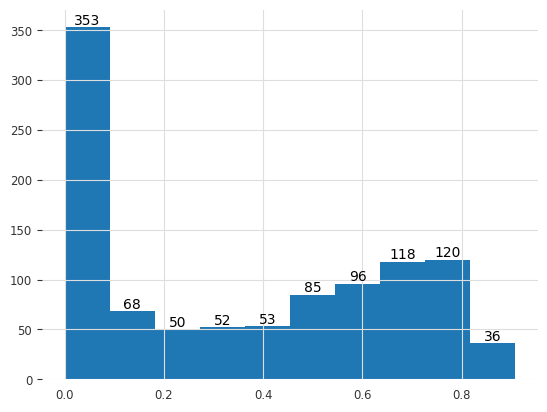

In [18]:
metrics_df['Val_Score'].hist()
print(len(metrics_df[metrics_df['Val_Score']>0]), metrics_df['Val_Score'].mean())
counts, edges, bars = plt.hist(metrics_df['Val_Score'], color = "#1f77b4")
plt.bar_label(container=bars)
plt.show()


In [19]:
metrics_df.to_csv('Arima_score_cov_18mnth.csv')